In [2]:
# google mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [10]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
from google.colab.patches import cv2_imshow

%matplotlib inline

from utils.openpose_net import OpenPoseNet

# Test Image
- Preprocessing 
- image -> np.array -> tensor

In [5]:
# load network
net = OpenPoseNet()

# read pretrained parameters
net_weights = torch.load('/content/drive/MyDrive/weights/pose_model_scratch.pth',
                         map_location={'cuda:0':'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# copy loaded parameters into net.state_dict().keys() in net.
for i in range(len(keys)):
  weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]

# weights into model 
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print("Success in setting a network: pretrained weights were loaded")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Success in setting a network: pretrained weights were loaded


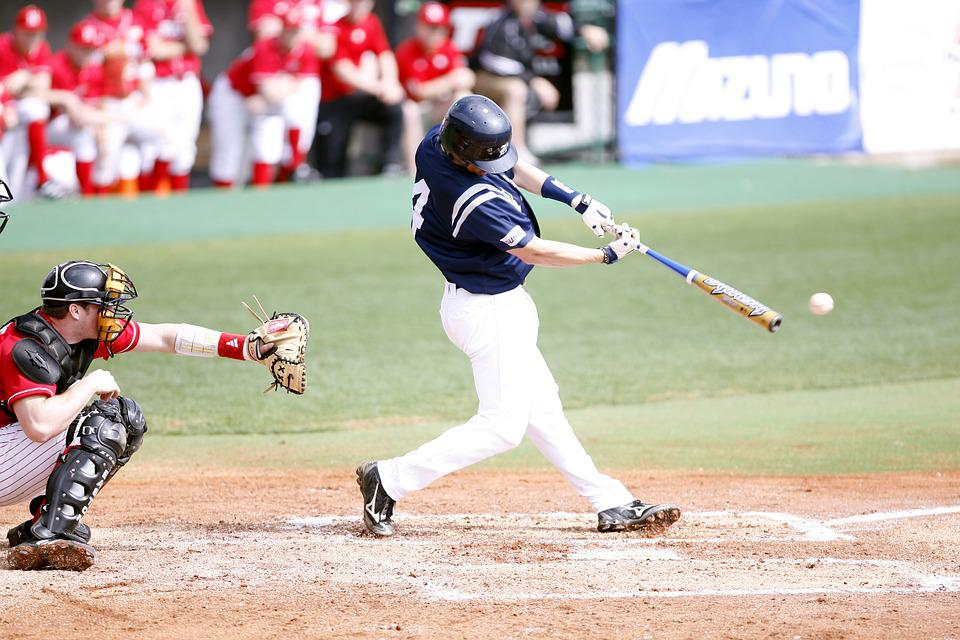

In [25]:
# read test image
test_image = '/content/drive/MyDrive/data/hit.jpg'
img = cv2.imread(test_image) # (B, G, R)
cv2_imshow(img)

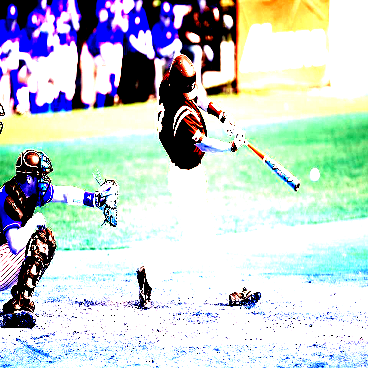

In [26]:
# resize image
size = (368, 368)
resize_img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)

# preprocessing image
img = resize_img.astype(np.float32) / 255.

# color standardization 
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

prep_img = img.copy()[:,:, ::-1] # BGR to RGB

for i in range(3):
  prep_img[:,:,i] = (prep_img[:,:,i] - color_mean[i]) / color_std[i]

cv2_imshow(prep_img*255)

# (height, width, channel) -> (channel, height, widht)
img = prep_img.transpose((2,0,1)).astype(np.float32)

# array to tensor
img = torch.from_numpy(img) # (3, 368, 368)
#print(img.shape) 

# reshape: torch.Size([1,3,368,368])
x = img.unsqueeze(0)

# Obtain confidence heatmap and PAFs from OpenPose

In [30]:
net.eval()
pred, _ = net(x)

In [21]:
pred[0].shape # PAFs

torch.Size([1, 38, 46, 46])

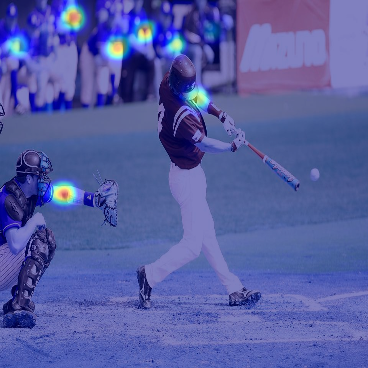

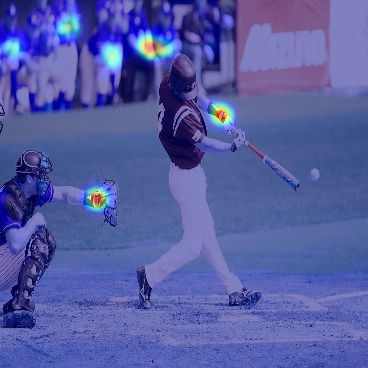

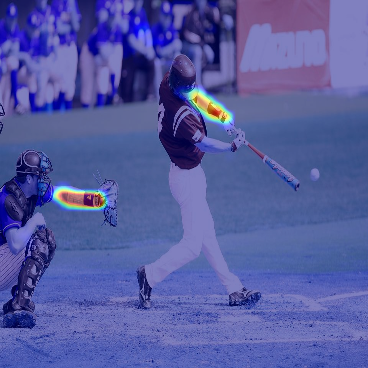

In [40]:
# tensor -> np.array
pafs = pred[0][0].detach().numpy().transpose(1,2,0) #(ch, h, w) -> (h,w,ch)
heatmaps = pred[1][0].detach().numpy().transpose(1,2,0)

pafs = cv2.resize(pafs, size, interpolation = cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation = cv2.INTER_CUBIC)

conf = heatmaps[:,:,6] # 6 represents left elbow
conf = Image.fromarray(np.uint8(cm.jet(conf)*255))
conf = np.asarray(conf.convert("RGB"))

# blending image
blend = cv2.addWeighted(resize_img, 0.5, conf, 0.5, 0)
blend = cv2.cvtColor(blend, cv2.COLOR_RGB2BGR)
cv2_imshow(blend)

# left wrist
heat_map = heatmaps[:, :, 7]  # 7: left wrist
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# bledning 
blend = cv2.addWeighted(resize_img, 0.5, heat_map, 0.5, 0)
blend = cv2.cvtColor(blend, cv2.COLOR_RGB2BGR)
cv2_imshow(blend)


# PAF vector b/w left elbow and left wrist : 24
paf = pafs[:, :, 24] 
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# blending
blend = cv2.addWeighted(resize_img, 0.5, paf, 0.5, 0)
blend = cv2.cvtColor(blend, cv2.COLOR_RGB2BGR)
cv2_imshow(blend)

# decode
- find link b/w body parts
- draw skeleton on original image
- input: confidence heatmap and PAFs
- output: skeleton image
- directory: ./utils/decode_pose.py

In [41]:
from utils.decode_pose import decode_pose
_, result, _, _ = decode_pose(resize_img, heatmaps, pafs)

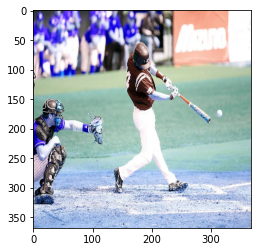

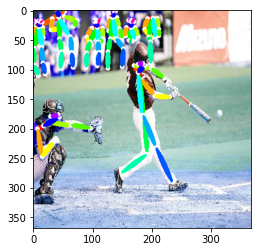

In [42]:
# draw the result image

plt.imshow(resize_img)
plt.show()

plt.imshow(result)
plt.show()